In [25]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
level_of_risk = pd.read_csv("level-of-risk.csv")
level_of_risk.head()

,operationId,controlId,level of risk,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [27]:
controls = pd.read_csv("controls.csv")
controls.head()

,controlId,title,Types
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
n_level_of_risk = len(level_of_risk)
n_controls = level_of_risk['controlId'].nunique()
n_operations = level_of_risk['operationId'].nunique()

print(f"Number of risk leveling: {n_level_of_risk}")
print(f"Number of unique controlId's: {n_controls}")
print(f"Number of unique operations: {n_operations}")
print(f"Average number of risk leveling per operation: {round(n_level_of_risk/n_operations, 2)}")
print(f"Average number of risk leveling per control: {round(n_level_of_risk/n_controls, 2)}")

Number of risk leveling: 100836
Number of unique controlId's: 9724
Number of unique operations: 610
Average number of risk leveling per operation: 165.3
Average number of risk leveling per control: 10.37


In [31]:
operation_freq = level_of_risk[['operationId', 'controlId']].groupby('operationId').count().reset_index()
operation_freq.columns = ['operationId', 'n_level_of_risk']
operation_freq.head()

,operationId,n_level_of_risk
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [33]:
print(f"Mean number of risk leveling for a given operation: {operation_freq['n_level_of_risk'].mean():.2f}.")

Mean number of risk leveling for a given operation: 165.30.


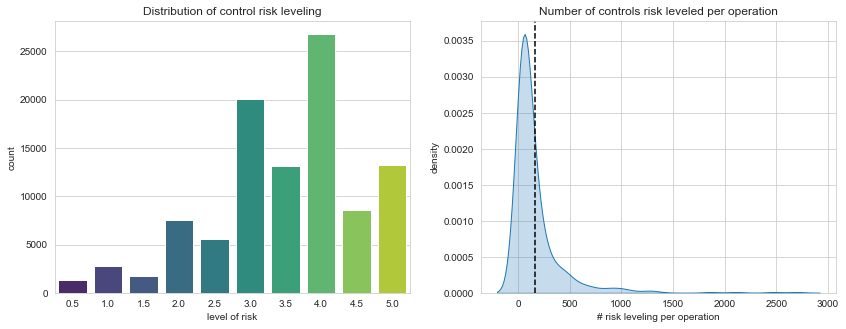

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="level of risk", data=level_of_risk, palette="viridis")
plt.title("Distribution of control risk leveling")

plt.subplot(1,2,2)
ax = sns.kdeplot(operation_freq['n_level_of_risk'], shade=True, legend=False)
plt.axvline(operation_freq['n_level_of_risk'].mean(), color="k", linestyle="--")
plt.xlabel("# risk leveling per operation")
plt.ylabel("density")
plt.title("Number of controls risk leveled per operation")
plt.show()

In [39]:
mean_risk_leveling = level_of_risk.groupby('controlId')[['level of risk']].mean()

lowest_risk_leveled = mean_risk_leveling['level of risk'].idxmin()
controls.loc[controls['controlId'] == lowest_risk_leveled]

,controlId,title,Types
2689,3604,Gypsy (1962),Musical


In [40]:
highest_risk_leveled = mean_risk_leveling['level of risk'].idxmax()
controls.loc[controls['controlId'] == highest_risk_leveled]

,controlId,title,Types
48,53,Lamerica (1994),Adventure|Drama


In [41]:
level_of_risk[level_of_risk['controlId']==highest_risk_leveled]

,operationId,controlId,level of risk,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [42]:
control_stats = level_of_risk.groupby('controlId')[['level of risk']].agg(['count', 'mean'])
control_stats.columns = control_stats.columns.droplevel()

In [43]:
C = control_stats['count'].mean()
m = control_stats['mean'].mean()

def bayesian_avg(level_of_risk):
    bayesian_avg = (C*m+level_of_risk.sum())/(C+level_of_risk.count())
    return bayesian_avg

bayesian_avg_level_of_risk = level_of_risk.groupby('controlId')['level of risk'].agg(bayesian_avg).reset_index()
bayesian_avg_level_of_risk.columns = ['controlId', 'bayesian_avg']
control_stats = control_stats.merge(bayesian_avg_level_of_risk, on='controlId')

In [45]:
control_stats = control_stats.merge(controls[['controlId', 'title']])
control_stats.sort_values('bayesian_avg', ascending=False).head()

,controlId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


In [46]:
control_stats.sort_values('bayesian_avg', ascending=True).head()

,controlId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


In [51]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        operation_mapper: dict that maps operation id's to operation indices
        operation_inv_mapper: dict that maps operation indices to operation id's
        control_mapper: dict that maps control id's to control indices
        control_inv_mapper: dict that maps control indices to control id's
    """
    N = df['operationId'].nunique()
    M = df['controlId'].nunique()

    operation_mapper = dict(zip(np.unique(df["operationId"]), list(range(N))))
    control_mapper = dict(zip(np.unique(df["controlId"]), list(range(M))))
    
    operation_inv_mapper = dict(zip(list(range(N)), np.unique(df["operationId"])))
    control_inv_mapper = dict(zip(list(range(M)), np.unique(df["controlId"])))
    
    operation_index = [operation_mapper[i] for i in df['operationId']]
    control_index = [control_mapper[i] for i in df['controlId']]

    X = csr_matrix((df["level of risk"], (control_index, operation_index)), shape=(M, N))
    
    return X, operation_mapper, control_mapper, operation_inv_mapper, control_inv_mapper

In [52]:
X, operation_mapper, control_mapper, operation_inv_mapper, control_inv_mapper = create_X(level_of_risk)

In [53]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [54]:
from scipy.sparse import save_npz

save_npz('operation_control_matrix.npz', X)

In [55]:
from numpy import load

data = load('operation_control_matrix.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

indices
[  0   4   6 ... 183 183 330]
indptr
[     0    215    325 ... 100834 100835 100836]
format
b'csr'
shape
[9724  610]
data
[4.  4.  4.5 ... 3.5 3.5 4. ]


In [59]:
from sklearn.neighbors import NearestNeighbors

def find_similar_controls(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given control id.
    
    Args:
        control_id: id of the safe control
        X: operation-control utility matrix
        k: number of similar control to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar control ID's
    """
    neighbour_ids = []
    
    control_ind = control_mapper[control_id]
    control_vec = X[control_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(control_vec, (np.ndarray)):
        control_vec = control_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(control_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(control_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [63]:
control_titles = dict(zip(controls['controlId'], controls['title']))

control_id = 1

similar_ids = find_similar_controls(control_id, X, k=10)
control_title = control_titles[control_id]

print(f"Because the opration done by {control_title} regarding the level of risk (and past incident similarity) as a safe control recommend:")
for i in similar_ids:
    print(control_titles[i])

Because the opration done by Toy Story (1995) regarding the level of risk (and past incident similarity) as a safe control recommend:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [64]:
control_titles = dict(zip(controls['controlId'], controls['title']))

control_id = 1
similar_ids = find_similar_controls(control_id, X, k=10, metric="euclidean")

control_title = control_titles[control_id]
print(f"Because the opration done by {control_title} regarding the level of risk (and past incident similarity) as a safe control recommend::")
for i in similar_ids:
    print(control_titles[i])

Because the opration done by Toy Story (1995) regarding the level of risk (and past incident similarity) as a safe control recommend::
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)
